In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import wkt

from os.path import exists
from os import makedirs

from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.colors import rgb2hex
from generativepy.color import Color                        # NOTE: additional package generativepy is required
from PIL import ImageColor

img_dir = './img/bivariate_maps/'
if not exists(img_dir):
    makedirs(img_dir)


ModuleNotFoundError: No module named 'generativepy'

# 1. Functions

## 1.1. Prepare DataFrames

In [ ]:
def read_district_data(year):
    data_dir = '../data/birthPlace_spain_v_outside/'
    file_extension = '_birthPlace_spain_v_outside.csv'
    file = str(year) + file_extension

    df = pd.read_csv(data_dir + file)
    df['Value'] = pd.to_numeric(df['Value'], errors='coerce').fillna(0).astype(int)     # convert to numeric, set NaN to 0
    df['Birth_Place'] = df['Birth_Place'].astype(str).str.strip()   # convert to str and strip spaces

    # if ignore_sex:
    df = df.groupby(['District', 'Birth_Place'], as_index=False)['Value'].sum()

    return df

def compute_district_total(df):
    # separate spain vs outside spain
    spain = df[df['Birth_Place'].isin(['City of Barcelona', 'Rest of Catalonia', 'Rest of Spain'])].groupby('District', as_index=False)['Value'].sum().rename(columns={'Value':'Population_Spain'})

    outside_spain = df[~df['Birth_Place'].isin(['City of Barcelona', 'Rest of Catalonia', 'Rest of Spain'])].groupby('District', as_index=False)['Value'].sum().rename(columns={'Value':'Population_outside_Spain'})    # also accounts for 'Not available'

    # merge into single dataframe
    spain_vs_outside = pd.merge(spain, outside_spain, on='District', how='outer').fillna(0)

    spain_vs_outside['Total_population'] = spain_vs_outside['Population_Spain'] + spain_vs_outside['Population_outside_Spain']
    spain_vs_outside['Percent_Spain'] = (spain_vs_outside['Population_Spain'] / spain_vs_outside['Total_population'] * 100).round(2)
    spain_vs_outside['Percent_outside_Spain'] = (spain_vs_outside['Population_outside_Spain'] / spain_vs_outside['Total_population'] * 100).round(2)

    return spain_vs_outside

def merge_district_geometry(spain_vs_outside):
    geometry_file = '../data/geometry/districts_geometry.csv'

    geometry_df = gpd.read_file(geometry_file)
    geometry_df['Geometry_etrs89'] = geometry_df['Geometry_etrs89'].apply(wkt.loads)    # convert WKT strings to shapes

    gdf = gpd.GeoDataFrame(geometry_df, geometry='Geometry_etrs89', crs="EPSG:25831")
    gdf['Area'] = gdf['Geometry_etrs89'].area / 1e6  # area in square kilometers

    plot_df = pd.merge(gdf, spain_vs_outside, left_on='District', right_on='District', how='left')
    plot_df['Density'] = (plot_df['Total_population'] / plot_df['Area']).round(2)  # population density per square kilometer

    return plot_df


## 1.2. Prepare Bivariate Colors

In [ ]:
def hex_to_Color(hexcode):
    'convert hex color to Color object'
    rgb = ImageColor.getcolor(hexcode, 'RGB')
    rgb = [v / 256 for v in rgb]

    return Color(*rgb)

def generate_colorlist(percentile_bounds):
    'generate bivariate color list through interpolation'
    # corner colors
    c00 = hex_to_Color('#f3f3f3')
    c10 = hex_to_Color('#e1a800')
    c01 = hex_to_Color('#8997c4')
    c11 = hex_to_Color('#000000')

    # color grid through interpolation
    n = len(percentile_bounds)

    c00_to_c10 = []
    c01_to_c11 = []

    colorlist = []

    for i in range(n):
        c00_to_c10.append(c00.lerp(c10, 1 / (n - 1) * i))
        c01_to_c11.append(c01.lerp(c11, 1 / (n - 1) * i))
    for i in range(n):
        for j in range(n):
            colorlist.append(c00_to_c10[i].lerp(c01_to_c11[i], 1 / (n - 1) * j))

    colorlist = [rgb2hex([c.r, c.g, c.b]) for c in colorlist]

    return colorlist

def get_grid_color(p1, p2, percentile_bounds, colorlist):
    'get bivariate color from two percentiles p1 and p2'
    color = [0.8, 0.8, 0.8, 1]

    if p1 >= 0 and p2 >= 0:
        count = 0
        stop = False
        for percentile_bound_p1 in percentile_bounds:
            for percentile_bound_p2 in percentile_bounds:
                if (not stop) and (p1 <= percentile_bound_p1):
                    if (not stop) and (p2 <= percentile_bound_p2):
                        color = colorlist[count]
                        stop = True
                count += 1
    return color


## 1.3. Plots

In [ ]:
def plot_immigration(year, ax):
    df = read_district_data(year)
    df = compute_district_total(df)
    gdf = merge_district_geometry(df)

    gdf.plot(column='Percent_outside_Spain', ax=ax, cmap='OrRd', vmin=0, vmax=100, legend=True, legend_kwds={'label': 'Percentage of Population from outside Spain', 'orientation': 'vertical', 'fraction':0.046, 'pad':0.04})
    ax.axis('off')
    gdf.boundary.plot(ax=ax, color='black', linewidth=0.4, zorder=3)

def plot_density(year, ax):
    df = read_district_data(year)
    df = compute_district_total(df)
    gdf = merge_district_geometry(df)

    gdf.plot(column='Density', ax=ax, cmap='OrRd', vmin=6000, vmax=34000, legend=True, legend_kwds={'label': 'Population Density per km$^2$', 'orientation': 'vertical', 'fraction':0.046, 'pad':0.04})
    ax.axis('off')
    gdf.boundary.plot(ax=ax, color='black', linewidth=0.4, zorder=3)

def plot_bivariate(year, ax):
    # gdf preparation
    df = read_district_data(year)
    district_df = compute_district_total(df)
    gdf = merge_district_geometry(district_df)

    gdf['Density_percentile'] = (gdf['Density'].rank(pct=True) * 100) - 5
    gdf['Inmigration_percentile'] = (gdf['Percent_outside_Spain'].rank(pct=True) * 100) - 5   

    percentile_bounds = [i * 20 + 0.01 for i in range(1, 6)]  # 5x5 grid
    colorlist = generate_colorlist(percentile_bounds)

    gdf['Color'] = [get_grid_color(p1, p2, percentile_bounds, colorlist) for p1, p2 in zip(gdf['Inmigration_percentile'], gdf['Density_percentile'])]


    # colormap
    gdf.plot(ax=ax, color=gdf['Color'])
    gdf.boundary.plot(ax=ax, color='black', linewidth=0.4, zorder=3)
    ax.axis('off')


    # inset legend
    ax = ax.inset_axes([0.8, 0.1, 0.2, 0.2])
    ax.set_aspect('equal', adjustable='box')
    count = 0
    xticks = [0]
    yticks = [0]
    for i, percentile_bound_p1 in enumerate(percentile_bounds):
        for j, percentile_bound_p2 in enumerate(percentile_bounds):
            percentileboxes = [Rectangle((i, j), 1, 1)]
            pc = PatchCollection(percentileboxes, facecolor=colorlist[count], zorder=1)
            count += 1
            ax.add_collection(pc)
            if i == 0:
                yticks.append(percentile_bound_p2)
        xticks.append(percentile_bound_p1)

    ax.set_xlim([0, len(percentile_bounds)])
    ax.set_ylim([0, len(percentile_bounds)])
    ax.set_xlabel('Immigration')
    ax.set_ylabel('Density')
    ax.set_xticks([])
    ax.set_yticks([])


    # scatter points in inset legend
    scatter_ax = ax.inset_axes([0, 0, 1, 1], zorder=10)
    scatter_ax.set_xlim(0, 100)
    scatter_ax.set_ylim(0, 100)
    scatter_ax.set_xticks([])
    scatter_ax.set_yticks([])

    scatter_ax.scatter(gdf['Inmigration_percentile'].values, gdf['Density_percentile'].values, color='#d85047', marker='x', s=10, alpha=0.9)

    scatter_ax.set_facecolor((1, 1, 1, 0))  # transparent background so the legend shows through the scatter points


# 2. Plots

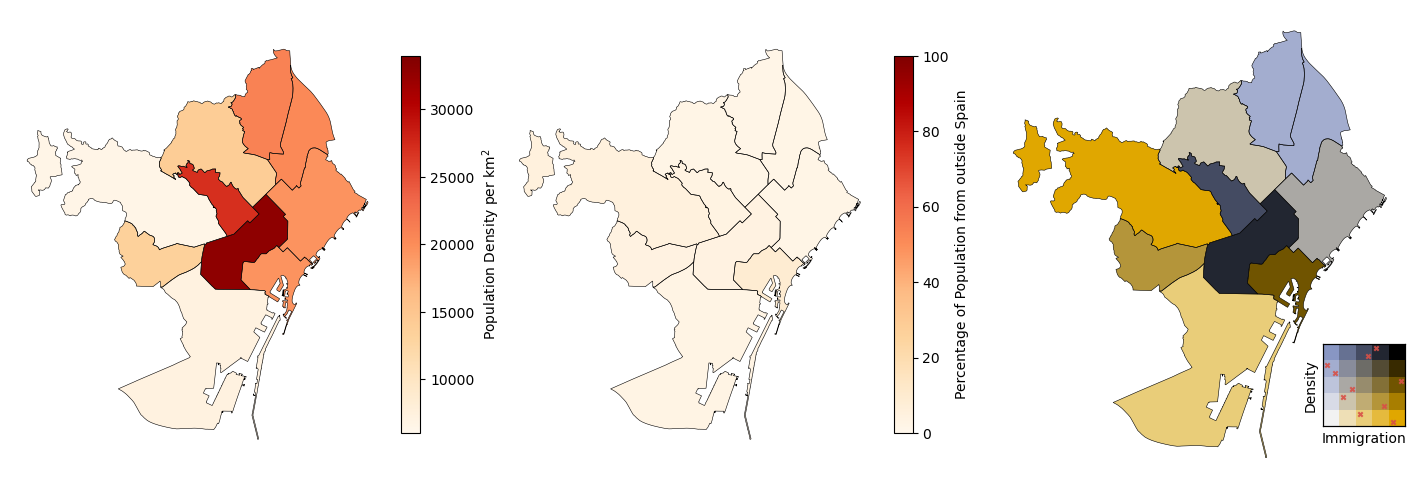

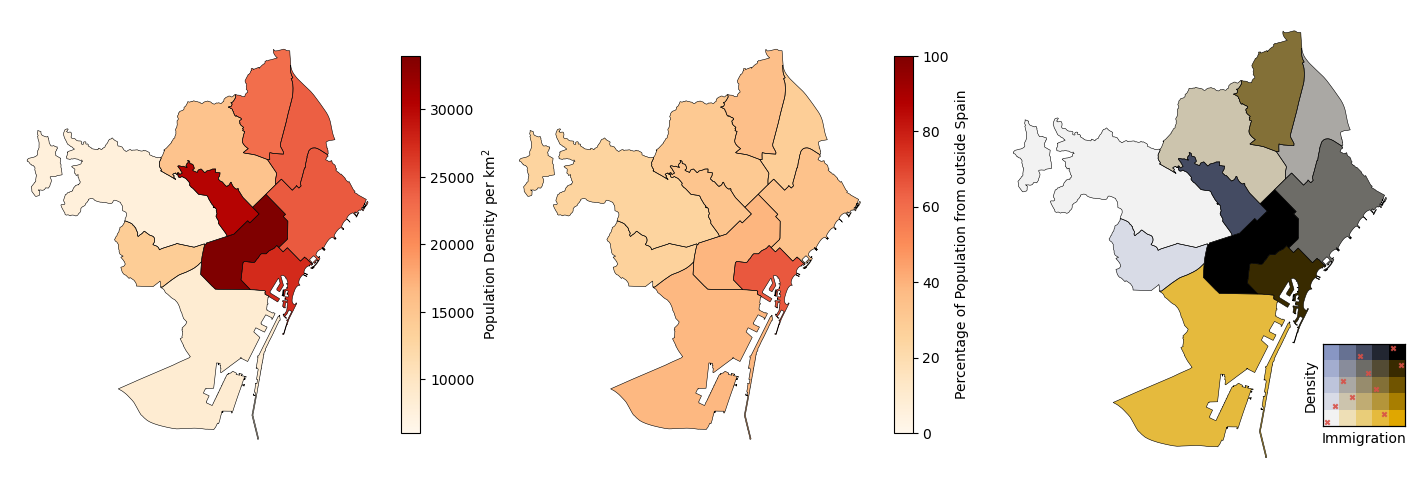

In [ ]:
years = [1997, 2025]

for year in years:
    fig, ax = plt.subplots(1, 3, figsize=(18, 12))

    # import textwrap
    # wrap = lambda s, w=30: "\n".join(textwrap.wrap(s, w))
    # ax[0].set_title(wrap('Percentage of Population from outside Spain (' + str(year) + ')', 30), fontsize=14)
    # ax[1].set_title(wrap('Percentile Bivariate: Immigration vs Density (' + str(year) + ')', 30), fontsize=14)
    # ax[2].set_title(wrap('Population Density (' + str(year) + ')', 30), fontsize=14)

    plot_density(year, ax[0])
    plot_immigration(year, ax[1])
    plot_bivariate(year, ax[2])

    plt.savefig(img_dir + 'bivariate_map_' + str(year) + '.png', dpi=300, bbox_inches='tight')
